# Human Activity Recognition

## Abstract

Human activity recognition plays a significant role in human-to-human interaction and interpersonal relations. To enhance the study in the field of human interaction we have classified the human activity performed using Deep Learning. As ‘Deep Learning’ is the idea of this decade, we have implemented one of the first advances in deep learning for object detection i.e. Long Short-Term Memory network(LSTM) a special kind of Recurrent Neural Network(RNN), capable of learning long-term dependencies. <br />
The research is performed on data collected from accelerometer and gyroscope sensors built from the recordings of 30 participants performing activities of daily living while carrying a waist-mounted smartphone with embedded inertial sensors. The objective is to classify activities into one of the six activities performed viz WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING. <br />
Our goal for this project was to showcase that standard machine learning algorithms cannot predict sequential classification problems better whereas the same can be predicted accurately with deep neural networks. With the given data, we started with analyzing the data using exploratory data analysis, later applied machine learning algorithms like SVC, Decision Tree to classify the activities. As the data contains sequential values implemented RNN using Keras and then developed an Android App to track the activity performed for which we developed an LSTM model in TensorFlow. We finally created a webpage that can display this tracked data for the person who plans to monitor this activity. This application can be used to monitor patients activities by doctors, suspected criminals activities by investigating agencies, etc. <br />

In [1]:
#importing required datasets
import pandas as pd
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import os

C:\Users\prith\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

## Importing Data

Importing train and test data from 9 files

In [3]:
#input file names
INPUT_SIGNAL_TYPES = [
    #"body_acc_x_",
    #"body_acc_y_",
    #"body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

#classification lables
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

In [4]:
#path to train and test data
TRAIN = "UCI HAR Dataset\\train\\"
TEST = "UCI HAR Dataset\\test\\"
#importing featurese and subjects text files
feature561_df = pd.read_csv('UCI HAR Dataset\\features.txt',header= None, sep='\s+')
subjectTrain_df = pd.read_csv('UCI HAR Dataset\\train\\subject_train.txt',header= None, sep='\s+')

In [5]:
#Load X (train + test)
def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

In [6]:
#Load y (train + test)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    #Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = TRAIN + "y_train.txt"
y_test_path = TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

As the dataset is a 3-D matrix, we converted it to a (7352 X 768) data frame to implement the standard neural network models.

In [7]:
#Converting 3D dataframe to 2D to implement standard neural network algorithms
#xtrain_df = pd.DataFrame(X_train.reshape(len(X_train),1152))
xtrain_df = pd.DataFrame(X_train.reshape(len(X_train),768))
ytrain_df = pd.DataFrame(y_train.reshape(len(y_train),1))
#xtest_df = pd.DataFrame(X_test.reshape(len(X_test),1152))
xtest_df = pd.DataFrame(X_test.reshape(len(X_test),768))
ytest_df = pd.DataFrame(y_test.reshape(len(y_test),1))

## Exploratory Data Analysis

To get a better understanding of the dataset <br />
•	7352 observations each having 128 data points taken within 2.56 seconds <br />
•	Each observation has 3 variables for x, y and z axis respectively divided in 9 files <br />
•	These observations have been taken for 21 users <br />
•	These activities are walking, walking upstairs, walking downstairs, sitting, standing and laying <br />

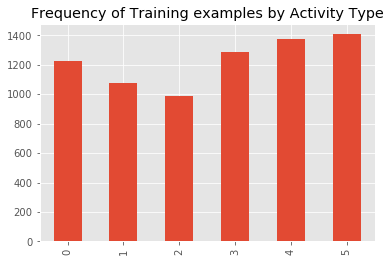

In [8]:
#Plotting the frequency of training data by activity type
plt.show(ytrain_df[0].value_counts().sort_index().plot(kind='bar', title='Frequency of Training examples by Activity Type'))

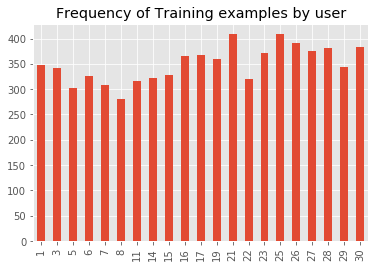

In [9]:
#Plotting the frequency of training data by user
plt.show(subjectTrain_df[0].value_counts().sort_index().plot(kind='bar', title='Frequency of Training examples by user'))

In [10]:
#adding fetaures as headers to xtrain
#xtrain_df.columns=feature561_df[1]
ytrain_df.columns=['Activity']
subjectTrain_df.columns=['User']

In [11]:
#concatinating activity and user columns to each observation
train_df=pd.concat([xtrain_df,ytrain_df,subjectTrain_df], axis=1)

In [12]:
#User-wise Activity frequency
pd.crosstab(train_df.User, train_df.Activity)

Activity,0,1,2,3,4,5
User,,,,,,
1,95,53,49,47,53,50
3,58,59,49,52,61,62
5,56,47,47,44,56,52
6,57,51,48,55,57,57
7,57,51,47,48,53,52
8,48,41,38,46,54,54
11,59,54,46,53,47,57
14,59,54,45,54,60,51
15,54,48,42,59,53,72


## Implementing Machine Learning algorithms

Prove that standard neural networks fail to get the best results while implementing on sequential classification data. With exploratory data analysis done, we moved on to implementing machine learning models on the dataset. As the dataset is a 3-D matrix, we converted it to a (7352 X 1152) dataframe to implement these models.

In [13]:
#importing standard neural network libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score # for evaluation
from sklearn.metrics import confusion_matrix

In [14]:
classifiers = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(7), # because there are 6 different labels
    SVC(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(xtrain_df, ytrain_df)
    ypred = clf.predict(xtest_df)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(ypred, ytest_df))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

C:\Users\prith\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]
C:\Users\prith\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prith\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Score
Model,
DecisionTreeClassifier,0.721072
KNeighborsClassifier,0.609094
SVC,0.788259
GaussianNB,0.720394
QuadraticDiscriminantAnalysis,0.705463


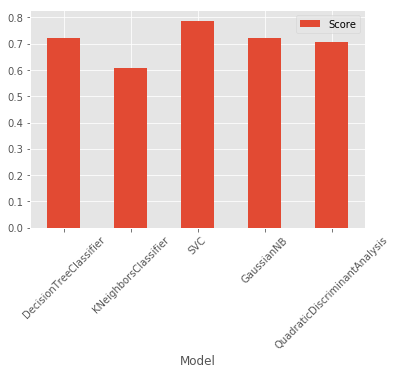

In [15]:
ax = score_df.plot.bar()
ax.set_xticklabels(score_df.index, rotation=45, fontsize=10)

In [16]:
#implementing only svc classification as it has the highest accuracy
svc_model_linear = SVC(kernel = 'linear', C = 1).fit(xtrain_df, ytrain_df)
svc_predictions = svc_model_linear.predict(xtest_df)

C:\Users\prith\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
#model accuracy for X_test  
accuracy = svc_model_linear.score(xtest_df, ytest_df)
accuracy

0.5975568374618256

In [18]:
#creating a confusion matrix
cm = confusion_matrix(ytest_df, svc_predictions)
cm

array([[162,  85,  91,  54, 104,   0],
       [ 91, 217,  43,  35,  85,   0],
       [133,  62, 104,  47,  74,   0],
       [  1,  25,   0, 372,  93,   0],
       [  3,  76,   8,  76, 369,   0],
       [  0,   0,   0,   0,   0, 537]], dtype=int64)

As expected there were a lot of prediction errors while implementing these algorithms, hence we decided to implement recurrent neural networks using Keras to improve the accuracy of the model.
To add a Recurrent layer, we make use of a Gated Recurrent Unit (GRU) layer with 32 units. It has reset gate applied to hidden state before matrix multiplication.

## Implementing Recurrent Neural Networks with keras

•	Implemented RNN with 50 epochs to get 83.37% validation accuracy

In [49]:
#importing required keras libraries
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [50]:
#initializing modle parameters
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, X_train.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
'''history = model.fit_generator(x=X_train,y_train,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=X_test,
                              validation_steps=val_steps)'''

'history = model.fit_generator(,y_train,\n                              steps_per_epoch=500,\n                              epochs=20,\n                              validation_data=X_test,\n                              validation_steps=val_steps)'

We tried using different optimizers such as SDG, RMSprop and Adam. Adam turned out be give best results for our data. After this we train our model for 50 epochs.

In [51]:
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=200,
                    epochs=50,
                    verbose=1,
                    callbacks=None,
                    #validation_split=0.2,
                    validation_data = (X_test, y_test),
                    #validation_data=None,
                    shuffle=True,
                    #class_weight=None, sample_weight=None,initial_epoch=0, steps_per_epoch=None, validation_steps=None
                   )

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 7s 961us/step - loss: 2.3626 - acc: 0.1544 - val_loss: 1.8847 - val_acc: 0.1795
Epoch 2/50
7352/7352 [==============================] - 4s 476us/step - loss: 1.4767 - acc: 0.2212 - val_loss: 1.1820 - val_acc: 0.2385
Epoch 3/50
7352/7352 [==============================] - 4s 482us/step - loss: 1.0514 - acc: 0.3569 - val_loss: 1.0373 - val_acc: 0.3943
Epoch 4/50
7352/7352 [==============================] - 3s 457us/step - loss: 0.9784 - acc: 0.4109 - val_loss: 1.0092 - val_acc: 0.4099
Epoch 5/50
7352/7352 [==============================] - 3s 441us/step - loss: 0.9390 - acc: 0.4298 - val_loss: 0.9697 - val_acc: 0.4143
Epoch 6/50
7352/7352 [==============================] - 3s 448us/step - loss: 0.8761 - acc: 0.4323 - val_loss: 0.8767 - val_acc: 0.4072
Epoch 7/50
7352/7352 [==============================] - 3s 461us/step - loss: 0.7198 - acc: 0.4396 - val_loss: 0.6541 - val_acc: 0.4571


In [52]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

C:\Users\prith\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


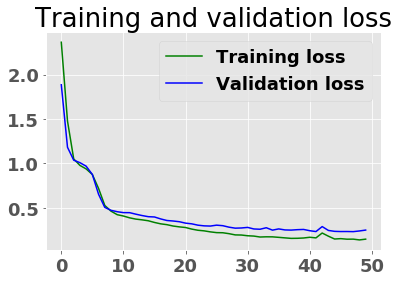

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

C:\Users\prith\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


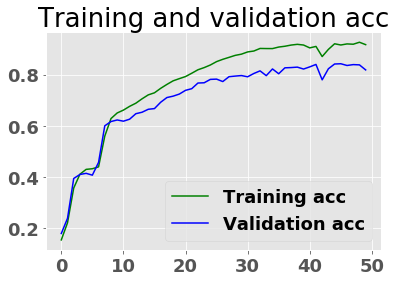

In [54]:
loss = history.history['acc']
val_loss = history.history['val_acc']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'g', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.show()

We tried splitting training data into training and validation sets. This decreased our accuracy as we had less data to train. Rather we use test data to validate our model. This gives us training accuracy of 91.68% and a validation accuracy of 81.81%

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

## LSTM using Tensorflow

•	Implemented LSTM with tensorflow to get 89.78% validation accuracy

In [19]:
#importinig required libraries for LSTM
import tensorflow as tf  # Version 1.0.0
from sklearn import metrics
import os

In [20]:
#input data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep

In [21]:
#LSTM Neural Network's internal structure
n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)

In [22]:
#training 
learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training

In [23]:
def LSTM_RNN(_X, _weights, _biases):
    #input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    #Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    #new shape: (n_steps*batch_size, n_input)
    
    #Linear activation
    _X = tf.nn.tanh(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    #Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    #new shape: n_steps * (batch_size, n_hidden)

    #Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    #Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    #Get last time step's output feature for a "many to one" style classifier, 
    #as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    #Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

In [24]:
#function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
def extract_batch_size(_train, step, batch_size):
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s

In [25]:
#function to encode output labels from number indexes
def one_hot(y_):
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [26]:
#graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

In [27]:
#graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden]),name='input'), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [28]:
pred = LSTM_RNN(x, weights, biases)

Instructions for updating:
Use the retry module or similar alternatives.


In [29]:
pred_softmax = tf.nn.softmax(pred, name="y_")

In [30]:
#add l2 to prevent over-fitting
l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() ) 
# L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) +l2 # Softmax loss
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [31]:
correct_pred = tf.equal(tf.argmax(pred_softmax,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [32]:
#to keep track of training's performance
saver = tf.train.Saver()
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

In [33]:
#launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

In [34]:
#perform training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs = extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    #fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)
    
    #evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        #to not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        #evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        history['test_loss'].append(loss)
        history['test_acc'].append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

Training iter #1500:   Batch Loss = 2.743232, Accuracy = 0.2460000067949295
PERFORMANCE ON TEST SET: Batch Loss = 2.380185604095459, Accuracy = 0.31286054849624634
Training iter #30000:   Batch Loss = 1.335047, Accuracy = 0.7253333330154419
PERFORMANCE ON TEST SET: Batch Loss = 1.4924068450927734, Accuracy = 0.6392942070960999
Training iter #60000:   Batch Loss = 1.159873, Accuracy = 0.7639999985694885
PERFORMANCE ON TEST SET: Batch Loss = 1.320229172706604, Accuracy = 0.7064811587333679
Training iter #90000:   Batch Loss = 1.166115, Accuracy = 0.7646666765213013
PERFORMANCE ON TEST SET: Batch Loss = 1.2524032592773438, Accuracy = 0.7360027432441711
Training iter #120000:   Batch Loss = 0.801856, Accuracy = 0.9126666784286499
PERFORMANCE ON TEST SET: Batch Loss = 1.1164031028747559, Accuracy = 0.8357651829719543
Training iter #150000:   Batch Loss = 0.729702, Accuracy = 0.9366666674613953
PERFORMANCE ON TEST SET: Batch Loss = 1.0832240581512451, Accuracy = 0.8435697555541992
Training i

PERFORMANCE ON TEST SET: Batch Loss = 0.6883255243301392, Accuracy = 0.8873430490493774
Training iter #1500000:   Batch Loss = 0.390599, Accuracy = 0.9359999895095825
PERFORMANCE ON TEST SET: Batch Loss = 0.7044277191162109, Accuracy = 0.884628415107727
Training iter #1530000:   Batch Loss = 0.306467, Accuracy = 0.95333331823349
PERFORMANCE ON TEST SET: Batch Loss = 0.7213075757026672, Accuracy = 0.8897183537483215
Training iter #1560000:   Batch Loss = 0.354655, Accuracy = 0.9340000152587891
PERFORMANCE ON TEST SET: Batch Loss = 0.773838996887207, Accuracy = 0.8632507920265198
Training iter #1590000:   Batch Loss = 0.416148, Accuracy = 0.9193333387374878
PERFORMANCE ON TEST SET: Batch Loss = 0.7194231152534485, Accuracy = 0.8629114627838135
Training iter #1620000:   Batch Loss = 0.319215, Accuracy = 0.9660000205039978
PERFORMANCE ON TEST SET: Batch Loss = 0.6838383674621582, Accuracy = 0.8690193295478821
Training iter #1650000:   Batch Loss = 0.319087, Accuracy = 0.9446666836738586
PE

After the successful prediction, we thought of developing an Android App. The dataset available contains 9 variables with body acceleration, body gyroscope and total acceleration in all the three axes. The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low-frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain. <br />
<br />
For the Android app, we get 6 variables i.e. body gyroscope and total acceleration tri-axially. To reduce the body acceleration from total acceleration, the gravity factor should be deducted from the total acceleration. To get rid of the gravity factor, we tried two approaches viz implementing Butterworth low-pass filter and applying Machine Learning Algorithm. <br />
<br />
We tried getting the third variable by implementing Machine Learning algorithms (Linear Regression and Random Forest) as well as implementing the Butterworth low pass filter. Linear Regression gave an R square value of 0.22 while Random forest model was overfitting to the training data. Implementation of butterworth low pass filter didn't give values as expected in the training data and hence we finally decided to re-train the model ignoring the 3rd feature and using this newly built model to take run-time values from the smartphone

In [35]:
#importing pickle to 
import pickle
#pickle.dump(predictions, open("predictions_9ip.p", "wb"))
pickle.dump(history, open("history_6ip.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har_6ip.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har_6ip.ckpt")
#sess.close()

'./checkpoint/har_6ip.ckpt'

In [36]:
history = pickle.load(open("history_6ip.p", "rb"))
#predictions = pickle.load(open("predictions_9ip.p", "rb"))

In [37]:
# Accuracy for test data
one_hot_predictions, accuracy, final_loss = sess.run(
    [pred_softmax, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

In [38]:
test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))

FINAL RESULT: Batch Loss = 0.6390010714530945, Accuracy = 0.8853070735931396


In [39]:
font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

In [40]:
width = 12
height = 12
plt.figure(figsize=(width, height))

C:\Users\prith\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


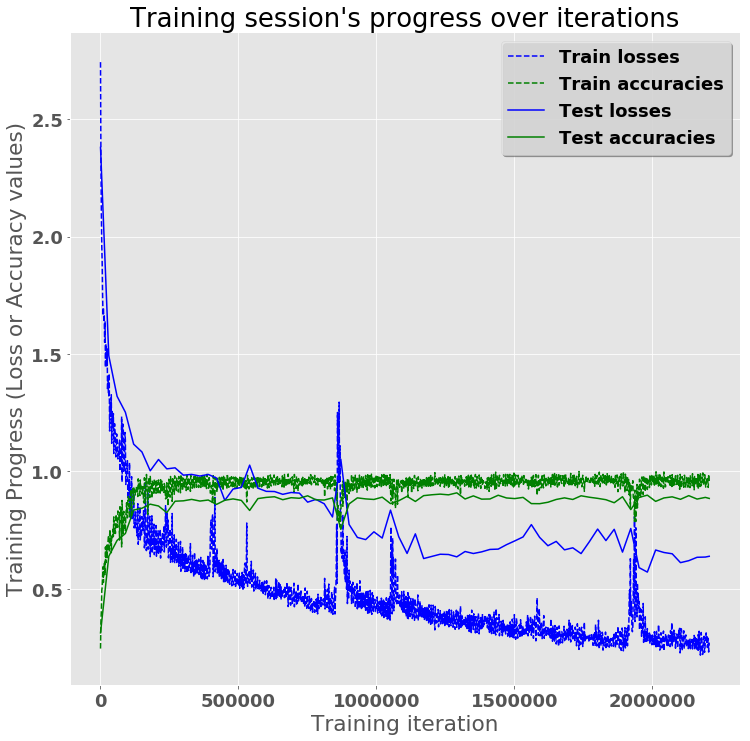

In [41]:
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

C:\Users\prith\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


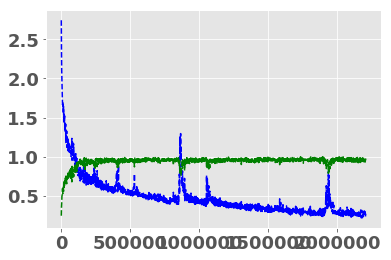

In [42]:
indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

In [43]:
indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)

C:\Users\prith\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


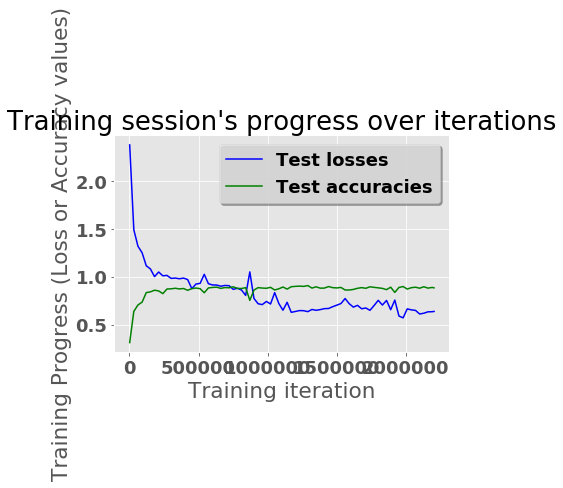

In [44]:
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

In [45]:
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")


Testing Accuracy: 88.53070735931396%

Precision: 88.88064712738894%
Recall: 88.53070919579234%
f1_score: 88.60744007095361%

Confusion Matrix:
[[440   2  54   0   0   0]
 [  1 438  32   0   0   0]
 [  7  26 386   0   1   0]
 [  0   1   0 402  88   0]
 [  4   1   0  94 433   0]
 [  0  27   0   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[14.930437    0.06786563  1.832372    0.          0.          0.        ]
 [ 0.03393281 14.862572    1.08585     0.          0.          0.        ]
 [ 0.2375297   0.88225317 13.098065    0.          0.03393281  0.        ]
 [ 0.          0.03393281  0.         13.640991    2.9860876   0.        ]
 [ 0.13573125  0.03393281  0.          3.1896844  14.692908    0.        ]
 [ 0.          0.916186    0.          0.          0.         17.305735  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


C:\Users\prith\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


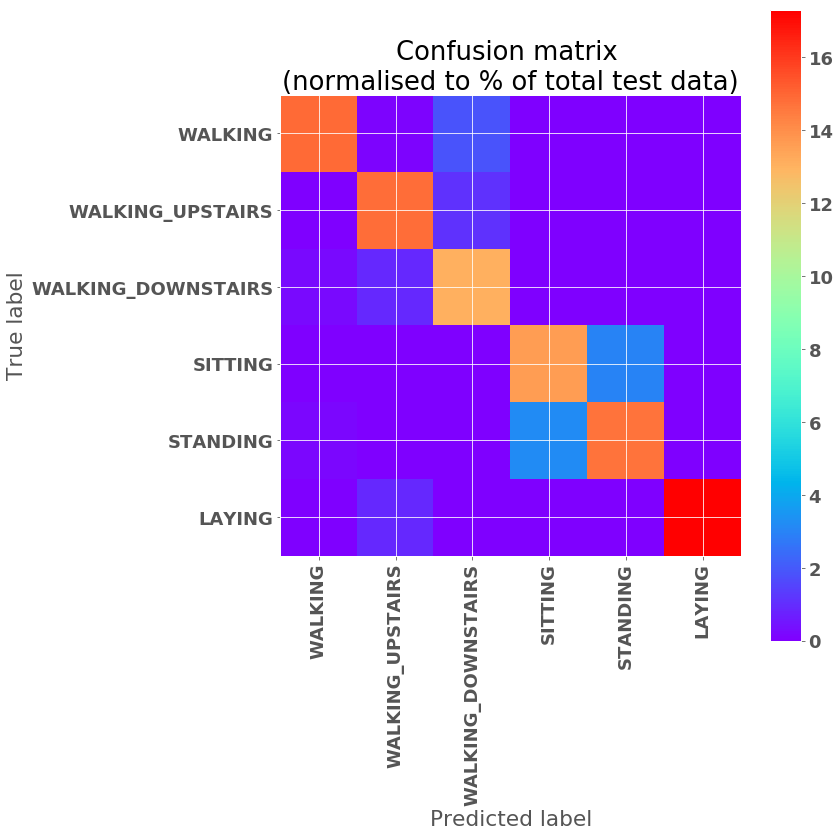

In [46]:
#plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [47]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har_6ip'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har_9ip.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.


In [48]:
sess.close()

# Results

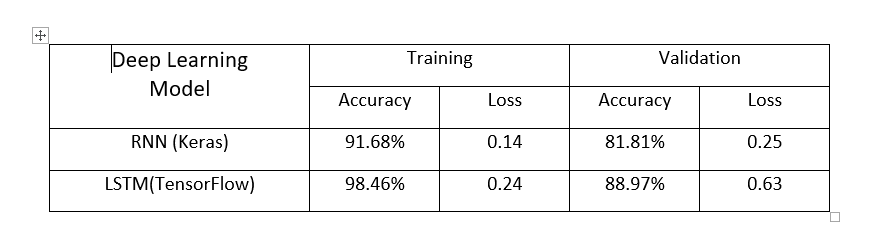

## Android App

We have further created an Android app that can collect the live accelerometer and gyroscope readings and using the above created tensorflow model, narrate the human activity and saves these activities in a temporary file.

## Flask API

Furthermore, flask API creates a web service, which reads data from this temporary file and displays it one the website. Android Code snippets and flask code snippets are included in the paper for better clarity.

# Future Scope

As part of the future scope we plan to implement the following: <br />
1) Inclusion of third variable for better precesion <br />
2) Android App enhancements with user better interface <br />

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.